In [21]:
""" 
    Author: Josue Castellanos

    Purpose: This notebook opens and reads the header and datasets from a HDF5 file from a Zygo Instrument

    Features:
        Read Intensity data
        Read Surface data
        Read Header data
"""

# Dependencies
import jczygoh5

filename = ''

**1) Which part of the hdf5 file is the surface, and which is the intensity, and which is the header?**

In [19]:
def ReadDatxFile(filename):
    surface_data_container = {'surface_data': None, 'base_unit': None, 'no_data_value': None}
    intensity_data_container = {'intensity_data': None, 'base_unit': None, 'no_data_value': None}
    # Helper function to process each item in the HDF5 file
    def _ProcessHeaderData(name, obj):
        global lat_res, cam_window

        print(f"{name}:")
        if isinstance(obj, h5py.Dataset) and 'Attributes/{' in name:
            name = name.split('Attributes/')[1]
            
        for key, val in obj.attrs.items():
                print(f"    {key}: {val}")
                try:
                    lat_res = f[f'{name}'].attrs['Data Context.Lateral Resolution:Value']
                except (KeyError):
                    pass
                try:
                    cam_window = f[f'{name}'].attrs['Data Context.Window']
                except (KeyError):
                    pass

    def _ProcessSurfaceData(name, obj):
        if isinstance(obj, h5py.Dataset) and 'Data/Surface' in name:
            # Retrieve the contents of the HDF5 dataset
            data = obj[()]
            attrs = {}
            for k, v in obj.attrs.items():
                attrs[k] = v
            surface_data_container['surface_data'] = data
            surface_data_container['base_unit'] = attrs['Z Converter']['BaseUnit']
            surface_data_container['no_data_value'] = attrs['No Data']

    def _ProcessIntensityData(name, obj):
        if isinstance(obj, h5py.Dataset) and 'Data/Intensity' in name:
            # Retrieve the contents of the HDF5 dataset
            intensity_data = obj[()]
            attrs = {}
            for k, v in obj.attrs.items():
                attrs[k] = v
            intensity_data_container['intensity_data'] = intensity_data
            intensity_data_container['base_unit'] = attrs['Z Converter']['BaseUnit']
            intensity_data_container['no_data_value'] = attrs['No Data']

    with h5py.File(filename, 'r') as f:
        f.visititems(_ProcessHeaderData)
        f.visititems(_ProcessIntensityData)
        f.visititems(_ProcessSurfaceData)

    surface_data = surface_data_container['surface_data']
    intensity_data = intensity_data_container['intensity_data']

    if surface_data is not None and intensity_data is not None:
        surface_data[surface_data == surface_data_container['no_data_value']] = np.nan
    return surface_data, surface_data_container['base_unit'], intensity_data, intensity_data_container['base_unit']

**Header Data**

In [20]:
surface_data, sbase_unit, intensity_data, ibase_unit = ReadDatxFile(filename)


OSError: [Errno 22] Unable to synchronously open file (unable to open file: name = '..epos\XROL_Image_Processing\ZygoNewViewar_edge_2.75x_portionTIny.datx', errno = 22, error message = 'Invalid argument', flags = 0, o_flags = 0)

**Surface Data**

In [ ]:
def SurfaceHeightValues(height_values, height_unit):
    if height_values is not None:
        # Calculate peak_valley and rms_value
        peak_valley = np.nanmax(height_values) - np.nanmin(height_values)
        rms_value = np.sqrt(np.nanmean((height_values - np.nanmean(height_values))**2))

        good_pixels = 0
        dead_pixels = 0
        # Print each value with its pixel coordinates
        rows, cols = height_values.shape
        for i in range(rows):
            for j in range(cols):
                # print(f"Pixel ({i}, {j}): {height_values[i, j]} {height_unit}")
                if np.isnan(height_values[i,j]):
                    dead_pixels += 1
                else:
                    good_pixels += 1

        # Print peak_valley and rms_value
        print("\n{0:0.3f} {2} PV, {1:0.3f} {2} RMS".format(peak_valley, rms_value, height_unit))
        print(f"Good Pixels Count: {good_pixels}")
        print(f"Dead Pixels Count: {dead_pixels}")
    else:
        print("Surface data not found.")

SurfaceHeightValues(surface_data, sbase_unit)


30.430 [b'Fringes'] PV, 8.591 [b'Fringes'] RMS
Good Pixels Count: 155834
Dead Pixels Count: 1284166


**Intensity Data**

In [ ]:
def IntensityValues(intensity_data, intensity_unit):
    intensity_values = intensity_data/255
    if intensity_values is not None:
        # Calculate max and mean intensity
        max_intensity = np.nanmax(intensity_values)
        mean_intensity = np.nanmean(intensity_values)

        # Print each value with its pixel coordinates
        rows, cols = intensity_values.shape
        intensity_dict = {}
        for i in range(rows):
            for j in range(cols):
                intensity_dict[f'Pixel ({i}, {j})'] = intensity_values[i, j]
                # print(f"Pixel ({i}, {j}): {intensity_values[i, j]} {intensity_unit}")

        # Print max and mean intensity
        print("{0:0.3f} {2} Max Intensity, {1:0.3f} {2} Mean Intensity".format(max_intensity, mean_intensity, intensity_unit))
    else:
        print("Intensity data not found.")

IntensityValues(intensity_data, ibase_unit)


2.451 [b'Counts'] Max Intensity, 0.188 [b'Counts'] Mean Intensity


**2) How long is the substrate?**
		
		To determine the length of the substrate from the Fizeau interferometer scan data, we need to extract relevant information 
    	about the lateral resolution and the dimensions of the scanned area. Here's how we can interpret the data provided:

		Lateral Resolution:
			Resolution: meters per pixel

		Camera Window:
			Window: (x_start, y_start, x_end, y_end) pixels

		Here's my calculation:
			Length of substrate = (x_end | y_end) x Resolution

In [ ]:
def SubstrateLength(cam_window, lat_res):    
    # Check if the necessary attributes were found
    if cam_window is not None and lat_res is not None:
        # Assuming cam_window is in the format (x_start, y_start, x_end, y_end)
        x_start, y_start, x_end, y_end = cam_window[0]
        
        global height_in_meters, width_in_meters
        # Perform the calculations
        height_in_meters = (y_end - y_start) * lat_res[0]
        width_in_meters = (x_end - x_start) * lat_res[0]

        # Length of the Substrate
        print(f"Height of substrate: {height_in_meters * 1000} millimeters")
        print(f"Width of substrate: {width_in_meters * 1000} millimeters")
    else:
        print("One or more necessary attributes are incorrect.")

SubstrateLength(cam_window, lat_res)

Height of substrate: 90.975822461158 millimeters
Width of substrate: 90.975822461158 millimeters


**2) How long is the substrate?**

        Fizeau data has the entire single picture at two magnifications (effective pixel sizes)

        Read the pixel size from the header “Lateral Resolution”**

        Throw out the no data flagged pixels (1.79769*10^308) and count how many good pixels there are of the surface (probably ~ 450, and 800 or so)

        Each row may have a slightly different count. Determine a statistical average


In [ ]:
def RowGoodPixelAvg(height_values):
    row = {}
 
    # Print each value with its pixel coordinates
    rows, cols = height_values.shape
    for i in range(rows):
        count = 0
        for j in range(cols):
            if np.isnan(height_values[i,j]):
                continue
            else:
                count += 1
        row[f'row {i}'] = count
    
    total = []
    height_count = 0

    for key, val in row.items():
        if val > 0:
            # print(f"{key}: {val}")
            total.append(val)
            height_count += 1
        else:
            pass
    average = np.average(total)

    print("\nNumber of Rows with Good Pixels: ", height_count)
    print("Average Pixels per Row: ", average)
RowGoodPixelAvg(surface_data)


Number of Rows with Good Pixels:  218
Average Pixels per Row:  714.8348623853211


**3) How to deal with dead points?**

        Accept the Dead Points within the Edges of the Substrate

        In each Column record the First and Last Row containing a Good Pixel

In [ ]:
def FirstLastGoodPixelRow(height_values):
    rows = height_values.shape[0]
    first_last = {}

    for i in range(rows):
        first_good = None
        last_good = None
        for j in range(height_values.shape[1]):
            if not np.isnan(height_values[i, j]):
                if first_good is None:
                    first_good = j
                last_good = j
        if first_good is not None:
            first_last[f'row {i}'] = {'first_good': first_good, 'last_good': last_good}

    for key, val in first_last.items():
        print(f"{key}: First good pixel at column {val['first_good']}, Last good pixel at column {val['last_good']}")

FirstLastGoodPixelRow(surface_data)

row 273: First good pixel at column 215, Last good pixel at column 215
row 274: First good pixel at column 214, Last good pixel at column 355
row 275: First good pixel at column 191, Last good pixel at column 925
row 276: First good pixel at column 189, Last good pixel at column 958
row 277: First good pixel at column 188, Last good pixel at column 968
row 278: First good pixel at column 187, Last good pixel at column 970
row 279: First good pixel at column 187, Last good pixel at column 971
row 280: First good pixel at column 187, Last good pixel at column 970
row 281: First good pixel at column 188, Last good pixel at column 970
row 282: First good pixel at column 187, Last good pixel at column 970
row 283: First good pixel at column 188, Last good pixel at column 971
row 284: First good pixel at column 188, Last good pixel at column 970
row 285: First good pixel at column 187, Last good pixel at column 970
row 286: First good pixel at column 187, Last good pixel at column 971
row 28

**3) From microscope stitching:**

        First consider the first and last measurements taken, where the edge can be seen.

        Read the “Lateral Resolution” and Y stage position “Y Attribute” from the header

        Again, determine the dead pixels, and ‘count’ the good pixels, this time in columns, and determine a statistical average of the length within the two fields of view.
        
        Reconciling this with the overlapping measurements of the middle regions is another matter… 


In [ ]:
def ColumnGoodPixelAvg(height_values):
    col = {}
 
    # Print each value with its pixel coordinates
    rows, cols = height_values.shape
    for i in range(cols):
        count = 0
        for j in range(rows):
            if np.isnan(height_values[j, i]):
                continue
            else:
                count += 1
        col[f'col {i}'] = count
    
    total = []
    count = 0

    for key, val in col.items():
        if val > 0:
            # print(f"{key}: {val}")
            total.append(val)
            count += 1
        else:
            pass
    average = np.average(total)

    print("\nNumber of Columns with Good Pixels: ", count)
    print("Average Pixels per Col: ", average)
ColumnGoodPixelAvg(surface_data)


Number of Columns with Good Pixels:  789
Average Pixels per Col:  197.50823827629912


In [ ]:
def FirstLastGoodPixelColumn(height_values):
    cols = height_values.shape[1]
    first_last = {}

    for i in range(cols):
        first_good = None
        last_good = None
        for j in range(height_values.shape[0]):
            if not np.isnan(height_values[j, i]):
                if first_good is None:
                    first_good = j
                last_good = j
        if first_good is not None:
            first_last[f'col {i}'] = {'first_good': first_good, 'last_good': last_good}
        

    for key, val in first_last.items():
        print(f"{key}: First good pixel at row {val['first_good']}, Last good pixel at row {val['last_good']}")

FirstLastGoodPixelColumn(surface_data)

col 185: First good pixel at row 349, Last good pixel at row 357
col 186: First good pixel at row 299, Last good pixel at row 790
col 187: First good pixel at row 278, Last good pixel at row 792
col 188: First good pixel at row 277, Last good pixel at row 793
col 189: First good pixel at row 276, Last good pixel at row 792
col 190: First good pixel at row 276, Last good pixel at row 792
col 191: First good pixel at row 275, Last good pixel at row 793
col 192: First good pixel at row 275, Last good pixel at row 793
col 193: First good pixel at row 276, Last good pixel at row 792
col 194: First good pixel at row 276, Last good pixel at row 794
col 195: First good pixel at row 276, Last good pixel at row 793
col 196: First good pixel at row 275, Last good pixel at row 792
col 197: First good pixel at row 275, Last good pixel at row 794
col 198: First good pixel at row 275, Last good pixel at row 794
col 199: First good pixel at row 276, Last good pixel at row 792
col 200: First good pixel

**Plots**

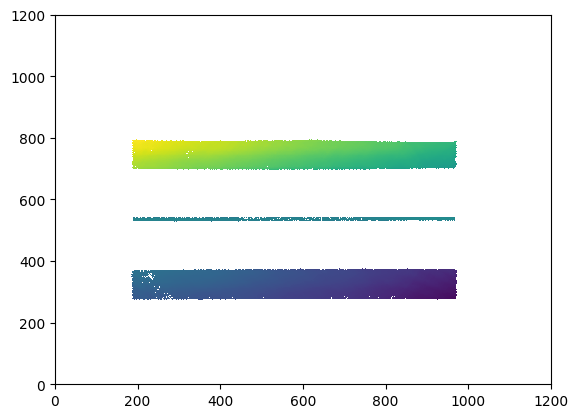

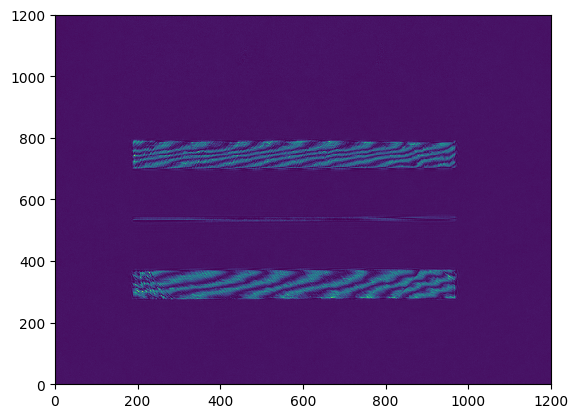